## based on Yuri's script,  find_summits.R

In [1]:
library(rtracklayer)
library(GenomicRanges)
library(plyr)
library(tidyverse)
library(data.table)

library(biosignals)

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomeInfoDb


Attaching package: ‘plyr’


The following object is masked from ‘package:IRanges’

In [2]:
root = '/Genomics/pritykinlab/zzhao/sc-atac-submmit-calling/sc-atac-submmit-calling'
motif_regression_out = "results/motif_regression_output/"
motif_regression_out = paste(root, motif_regression_out, sep="/")
# load peaks from archR, convert the format to bed first.
all.atac.peaks <- rtracklayer::import(paste(motif_regression_out, "MACS2_peaks.bed", sep="/"))

In [3]:
all.atac.peaks[1:100]

GRanges object with 100 ranges and 1 metadata column:
        seqnames          ranges strand |        name
           <Rle>       <IRanges>  <Rle> | <character>
    [1]     chr1     10017-10245      * |         230
    [2]     chr1   180708-180967      * |         261
    [3]     chr1   181337-181550      * |         215
    [4]     chr1   191364-191898      * |         536
    [5]     chr1   267887-268075      * |         190
    ...      ...             ...    ... .         ...
   [96]     chr1 1371275-1372309      * |        1036
   [97]     chr1 1374781-1375689      * |         910
   [98]     chr1 1385801-1385955      * |         156
   [99]     chr1 1389747-1389951      * |         206
  [100]     chr1 1398851-1399842      * |         993
  -------
  seqinfo: 16 sequences from an unspecified genome; no seqlengths

In [4]:
names(all.atac.peaks) <- sapply(1:length(all.atac.peaks), function(i) paste("peak", i, sep=""))

In [5]:
all.atac.peaks

GRanges object with 76714 ranges and 1 metadata column:
            seqnames              ranges strand |        name
               <Rle>           <IRanges>  <Rle> | <character>
      peak1     chr1         10017-10245      * |         230
      peak2     chr1       180708-180967      * |         261
      peak3     chr1       181337-181550      * |         215
      peak4     chr1       191364-191898      * |         536
      peak5     chr1       267887-268075      * |         190
        ...      ...                 ...    ... .         ...
  peak76710     chrX 155891443-155891682      * |         241
  peak76711     chrX 155966944-155967143      * |         201
  peak76712     chrX 155997284-155997767      * |         485
  peak76713     chrX 156030040-156030260      * |         222
  peak76714     chrX 156030504-156030679      * |         177
  -------
  seqinfo: 16 sequences from an unspecified genome; no seqlengths

In [6]:
# load bam coverage file (big wig format)
atac.signal <- rtracklayer::import(paste(motif_regression_out, "sc_atac_fragments.bw", sep="/"), as = "RleList")

In [7]:
head(atac.signal)

RleList of length 6
$chr1
numeric-Rle of length 248956422 with 18263779 runs
  Lengths: 10012     2    52     1     5 ...    17     1     5     1 10129
  Values :     0     1     0     2     0 ...     0     1     0     1     0

$chr10
numeric-Rle of length 133797422 with 8933732 runs
  Lengths: 10002     1   370     1    24 ...     4     1     5     2 10039
  Values :     0     1     0     1     0 ...     0     4     0     1     0

$chr11
numeric-Rle of length 135086622 with 9666418 runs
  Lengths: 113333      1     17      1    158 ...      1      4      1  10008
  Values :      0      1      0      1      0 ...      1      0      1      0

$chr12
numeric-Rle of length 133275309 with 9976156 runs
  Lengths: 10073     1     1     4     1 ...     3     1   403     1 10001
  Values :     0     1     3     0     1 ...     0     1     0     1     0

$chr13
numeric-Rle of length 114364328 with 4668834 runs
  Lengths: 17419451        1      294        1 ...       12        1    10121
  Value

In [7]:
# subsetting the bam coverage by archR picked peaks
peaks.signal <- atac.signal[all.atac.peaks]

In [8]:
names(peaks.signal) <- names(all.atac.peaks)

In [9]:
peaks.signal$peak1

numeric-Rle of length 229 with 72 runs
  Lengths: 50  1  5  1  1  5  1  4  1  1  4 ...  1  5  1  6  1  3  1  1  2  2
  Values :  0  2  0  2  1  0  6  0  3  4  0 ...  1  0  2  0  2  0  3  0  1  0

In [10]:
# summit calling using biosignals package from Leslie Lab: https://bitbucket.org/leslielab/biosignals
findVectorMax <- function(v, g0, g1, g2, min.dist = 150) {
    # pad zeros at the beginning and the end of the vector
    bw = as.integer(length(g0)/2)
    v = c(rep(0, bw), as.numeric(v), rep(0, bw))
    v.conv <- convolve1d(v, g0)[(bw+1):(length(v)-bw)]
    v.conv.d1 <- convolve1d(v, g1)[(bw+1):(length(v)-bw)]
    v.conv.d2 <- convolve1d(v, g2)[(bw+1):(length(v)-bw)]
    v.conv.d1.zero <- zeroCrossings(v.conv.d1)
    points.max <- v.conv.d1.zero[v.conv.d2[v.conv.d1.zero] < 0]
    if (length(points.max) == 0) {
        return(c())
    }
    points.max <- data.table(x = points.max)
    points.max$value <- v.conv[points.max$x]
    points.max <- points.max[order(-value)]
    vector.max <- c()
    for (i in 1:nrow(points.max)) {
        x <- points.max[i, ][, x]
        # instead of compare against the 0 and length of v, 
        if (min(abs(x - c(vector.max, -min.dist, (length(v.conv)+min.dist)))) >= min.dist) {
            vector.max <- c(vector.max, x)
        }
    }
    vector.max
}


In [11]:
gen_kernels <- function(bw) {
    g0 <- generateKernel("gaussian", bandwidth = bw, deriv = 0)
    g1 <- generateKernel("gaussian", bandwidth = bw, deriv = 1)
    g2 <- generateKernel("gaussian", bandwidth = bw, deriv = 2)
    list("g0"=g0, "g1"=g1, "g2"=g2)
}

In [23]:
kernels <- gen_kernels(150)
peaks.summits <- sapply(peaks.signal, function(peak) findVectorMax(peak, kernels$g0, kernels$g1, kernels$g2))

In [12]:
peaks.summits <- readRDS(paste(motif_regression_out, "SUMMITS-TMP-all-atac-peaks-summits-lists.rds", sep="/"))

In [16]:
head(peaks.summits, n=10)

$peak1
[1] 155

$peak2
[1] 199

$peak3
[1] 129

$peak4
[1] 487 168

$peak5
[1] 118

$peak6
[1] 94

$peak7
[1] 106

$peak8
[1] 113

$peak9
[1] 117

$peak10
[1] 425 122

In [17]:
summit.count <- sapply(peaks.summits, length)
peaks.s0.signal <- peaks.signal[summit.count == 0]
length(peaks.s0.signal)

[1] 0

In [20]:
length(peaks.signal[summit.count > 0])

[1] 76714

In [19]:
max(summit.count)

[1] 15

In [21]:
peaks.summits.final <- peaks.summits

In [22]:
print("prepare final set of regions around peak summits")
summit.width <- 150
peaks.summits.dt <- data.table(ldply(peaks.summits.final, matrix, .id = "peak"))
colnames(peaks.summits.dt) <- c("peak", "summit")
peaks.summits <- all.atac.peaks[peaks.summits.dt$peak, ]

[1] "prepare final set of regions around peak summits"


In [28]:
stopifnot(start(peaks.summits) + peaks.summits.dt$summit <= end(peaks.summits))
start(peaks.summits) <- start(peaks.summits) + peaks.summits.dt$summit
end(peaks.summits) <- start(peaks.summits)

In [30]:
peaks.summits$peak <- names(peaks.summits)
peaks.summits

GRanges object with 150007 ranges and 2 metadata columns:
            seqnames    ranges strand |        name        peak
               <Rle> <IRanges>  <Rle> | <character> <character>
      peak1     chr1     10172      * |         230       peak1
      peak2     chr1    180907      * |         261       peak2
      peak3     chr1    181466      * |         215       peak3
      peak4     chr1    191851      * |         536       peak4
      peak4     chr1    191532      * |         536       peak4
        ...      ...       ...    ... .         ...         ...
  peak76710     chrX 155891611      * |         241   peak76710
  peak76711     chrX 155967070      * |         201   peak76711
  peak76712     chrX 155997600      * |         485   peak76712
  peak76713     chrX 156030197      * |         222   peak76713
  peak76714     chrX 156030613      * |         177   peak76714
  -------
  seqinfo: 16 sequences from an unspecified genome; no seqlengths

In [31]:
peaks.summits$peak_position <- sapply(peaks.summits$peak, function (pk) {
    peak_info = all.atac.peaks[pk]
    paste(seqnames(peak_info), ":", start(ranges(peak_info)), "-", end(ranges(peak_info)), sep = "")
})
peaks.summits

GRanges object with 150007 ranges and 3 metadata columns:
            seqnames    ranges strand |        name        peak
               <Rle> <IRanges>  <Rle> | <character> <character>
      peak1     chr1     10172      * |         230       peak1
      peak2     chr1    180907      * |         261       peak2
      peak3     chr1    181466      * |         215       peak3
      peak4     chr1    191851      * |         536       peak4
      peak4     chr1    191532      * |         536       peak4
        ...      ...       ...    ... .         ...         ...
  peak76710     chrX 155891611      * |         241   peak76710
  peak76711     chrX 155967070      * |         201   peak76711
  peak76712     chrX 155997600      * |         485   peak76712
  peak76713     chrX 156030197      * |         222   peak76713
  peak76714     chrX 156030613      * |         177   peak76714
                     peak_position
                       <character>
      peak1       chr1:10017-10245
     

In [32]:
peaks.summits$peak <- peaks.summits$name
peaks.summits <- sort(peaks.summits)
peaks.summits$name <- paste0("summit", seq_along(peaks.summits))

names(peaks.summits) <- peaks.summits$name
peaks.summits <- resize(peaks.summits, width = summit.width, fix = "center")


In [33]:
peaks.summits 

GRanges object with 150007 ranges and 3 metadata columns:
               seqnames              ranges strand |         name        peak
                  <Rle>           <IRanges>  <Rle> |  <character> <character>
       summit1     chr1         10097-10246      * |      summit1         230
       summit2     chr1       180832-180981      * |      summit2         261
       summit3     chr1       181391-181540      * |      summit3         215
       summit4     chr1       191457-191606      * |      summit4         536
       summit5     chr1       191776-191925      * |      summit5         536
           ...      ...                 ...    ... .          ...         ...
  summit150003     chrX 155891536-155891685      * | summit150003         241
  summit150004     chrX 155966995-155967144      * | summit150004         201
  summit150005     chrX 155997525-155997674      * | summit150005         485
  summit150006     chrX 156030122-156030271      * | summit150006         222
  summ

In [34]:
write.table(as.data.frame(peaks.summits), paste(motif_regression_out, "SUMMITS-peak_summits.more_info.bed", sep="/"), quote= F, row.names = F, sep ="\t")


export(peaks.summits, paste(motif_regression_out, "SUMMITS-all-atac-summits.bed", sep="/"))


In [56]:
print("here")

[1] "here"


## now use smaller min distance, same kernel bandwidth

In [52]:
peaks.s0.summits <- sapply(peaks.s0.signal, findVectorMax, g0 = kernels$g0, g1 = kernels$g1, g2 = kernels$g2,
                           min.dist = 50)

summit.s0.count <- sapply(peaks.s0.summits, length)
peaks.s0.s0.signal <- peaks.s0.signal[summit.s0.count == 0]
peaks.s0.s0.signal.max <- sapply(peaks.s0.s0.signal, max)
peaks.s0.s0.signal.high <- peaks.s0.s0.signal[peaks.s0.s0.signal.max > 0.5]

In [57]:
print(length(peaks.s0.s0.signal))

[1] 5710


In [58]:
print(sum(summit.s0.count > 0))

[1] 20712


In [59]:
print(sum(summit.s0.count == 0))

[1] 5710


In [60]:
length(peaks.s0.s0.signal.high)

[1] 5710

## now use smaller bandwidth 

In [61]:
kernels_100bw <- gen_kernels(100)
peaks.s0.s0.high.summits <- sapply(peaks.s0.s0.signal.high, findVectorMax, g0 = kernels_100bw$g0, 
                                   g1 = kernels_100bw$g1, g2 = kernels_100bw$g2)


In [62]:
summit.s0.s0.high.count <- sapply(peaks.s0.s0.high.summits, length)


In [63]:
sum(summit.s0.s0.high.count > 0)

[1] 610

In [64]:
sum(summit.s0.s0.high.count == 0)

[1] 5100

In [65]:
peaks.summits.final <- c(peaks.summits[summit.count > 0],
                         peaks.s0.summits[summit.s0.count > 0],
                         peaks.s0.s0.high.summits[summit.s0.s0.high.count > 0])

In [66]:
length(peaks.summits.final)

[1] 71614

In [67]:
head(peaks.summits.final)

$peak4
[1] 168

$peak10
[1] 425 122

$peak11
[1] 120

$peak12
[1] 334

$peak13
[1] 825 178

$peak16
[1] 661 429 215

In [68]:
tail(peaks.summits.final)

$peak76174
[1] 105

$peak76296
[1] 134

$peak76374
[1] 153

$peak76465
[1] 203

$peak76495
[1] 108

$peak76548
[1] 167

In [69]:
length(peaks.signal)

[1] 76714

In [72]:
peaks.signal$peak4

numeric-Rle of length 535 with 144 runs
  Lengths: 12  1  2  1  6  1  9  1  1  1  1 ...  1  9  1  1  2  1  1  5  1  1
  Values :  0  1  0  1  0  1  0  1  3  0  1 ...  6  0  1  0  1  0  2  0  1  0

In [76]:
peaks.signal$peak4[72]

numeric-Rle of length 1 with 1 run
  Lengths: 1
  Values : 0

In [77]:
max(peaks.signal$peak2)

[1] 29

In [78]:
length(peaks.signal$peak2)

[1] 260

In [79]:
saveRDS(peaks.summits.final, paste(motif_regression_out, "SUMMITS-all-atac-peaks-summits-lists.rds", sep="/"))

# generate final set of regions around peak summits

In [80]:
tail(peaks.summits.final)

$peak76174
[1] 105

$peak76296
[1] 134

$peak76374
[1] 153

$peak76465
[1] 203

$peak76495
[1] 108

$peak76548
[1] 167

In [81]:
print("prepare final set of regions around peak summits")
summit.width <- 150
peaks.summits.dt <- data.table(ldply(peaks.summits.final, matrix, .id = "peak"))
colnames(peaks.summits.dt) <- c("peak", "summit")
peaks.summits <- all.atac.peaks[peaks.summits.dt$peak, ]

[1] "prepare final set of regions around peak summits"


In [82]:
stopifnot(start(peaks.summits) + peaks.summits.dt$summit <= end(peaks.summits))
start(peaks.summits) <- start(peaks.summits) + peaks.summits.dt$summit
end(peaks.summits) <- start(peaks.summits)

In [83]:
peaks.summits$peak <- names(peaks.summits)
peaks.summits

GRanges object with 119843 ranges and 2 metadata columns:
            seqnames    ranges strand |        name        peak
               <Rle> <IRanges>  <Rle> | <character> <character>
      peak4     chr1    191532      * |         536       peak4
     peak10     chr1    778722      * |         835      peak10
     peak10     chr1    778419      * |         835      peak10
     peak11     chr1    817101      * |         446      peak11
     peak12     chr1    821216      * |         611      peak12
        ...      ...       ...    ... .         ...         ...
  peak76296     chrX 136191357      * |         290   peak76296
  peak76374     chrX 138985097      * |         345   peak76374
  peak76465     chrX 150459312      * |         339   peak76465
  peak76495     chrX 151031009      * |         244   peak76495
  peak76548     chrX 153735449      * |         275   peak76548
  -------
  seqinfo: 16 sequences from an unspecified genome; no seqlengths

In [84]:
peaks.summits$peak_position <- sapply(peaks.summits$peak, function (pk) {
    peak_info = all.atac.peaks[pk]
    paste(seqnames(peak_info), ":", start(ranges(peak_info)), "-", end(ranges(peak_info)), sep = "")
})
peaks.summits

GRanges object with 119843 ranges and 3 metadata columns:
            seqnames    ranges strand |        name        peak
               <Rle> <IRanges>  <Rle> | <character> <character>
      peak4     chr1    191532      * |         536       peak4
     peak10     chr1    778722      * |         835      peak10
     peak10     chr1    778419      * |         835      peak10
     peak11     chr1    817101      * |         446      peak11
     peak12     chr1    821216      * |         611      peak12
        ...      ...       ...    ... .         ...         ...
  peak76296     chrX 136191357      * |         290   peak76296
  peak76374     chrX 138985097      * |         345   peak76374
  peak76465     chrX 150459312      * |         339   peak76465
  peak76495     chrX 151031009      * |         244   peak76495
  peak76548     chrX 153735449      * |         275   peak76548
                     peak_position
                       <character>
      peak4     chr1:191364-191898
     

In [85]:
peaks.summits$peak <- peaks.summits$name

In [86]:
peaks.summits <- sort(peaks.summits)
peaks.summits$name <- paste0("summit", seq_along(peaks.summits))

In [87]:
peaks.summits

GRanges object with 119843 ranges and 3 metadata columns:
            seqnames    ranges strand |         name        peak
               <Rle> <IRanges>  <Rle> |  <character> <character>
      peak1     chr1     10172      * |      summit1         230
      peak2     chr1    180917      * |      summit2         261
      peak3     chr1    181466      * |      summit3         215
      peak4     chr1    191532      * |      summit4         536
      peak5     chr1    268005      * |      summit5         190
        ...      ...       ...    ... .          ...         ...
  peak76709     chrX 155881281      * | summit119839         935
  peak76711     chrX 155967070      * | summit119840         201
  peak76712     chrX 155997600      * | summit119841         485
  peak76713     chrX 156030197      * | summit119842         222
  peak76714     chrX 156030613      * | summit119843         177
                     peak_position
                       <character>
      peak1       chr1:1001

In [88]:
names(peaks.summits) <- peaks.summits$name
peaks.summits <- resize(peaks.summits, width = summit.width, fix = "center")

In [89]:
peaks.summits

GRanges object with 119843 ranges and 3 metadata columns:
               seqnames              ranges strand |         name        peak
                  <Rle>           <IRanges>  <Rle> |  <character> <character>
       summit1     chr1         10097-10246      * |      summit1         230
       summit2     chr1       180842-180991      * |      summit2         261
       summit3     chr1       181391-181540      * |      summit3         215
       summit4     chr1       191457-191606      * |      summit4         536
       summit5     chr1       267930-268079      * |      summit5         190
           ...      ...                 ...    ... .          ...         ...
  summit119839     chrX 155881206-155881355      * | summit119839         935
  summit119840     chrX 155966995-155967144      * | summit119840         201
  summit119841     chrX 155997525-155997674      * | summit119841         485
  summit119842     chrX 156030122-156030271      * | summit119842         222
  summ

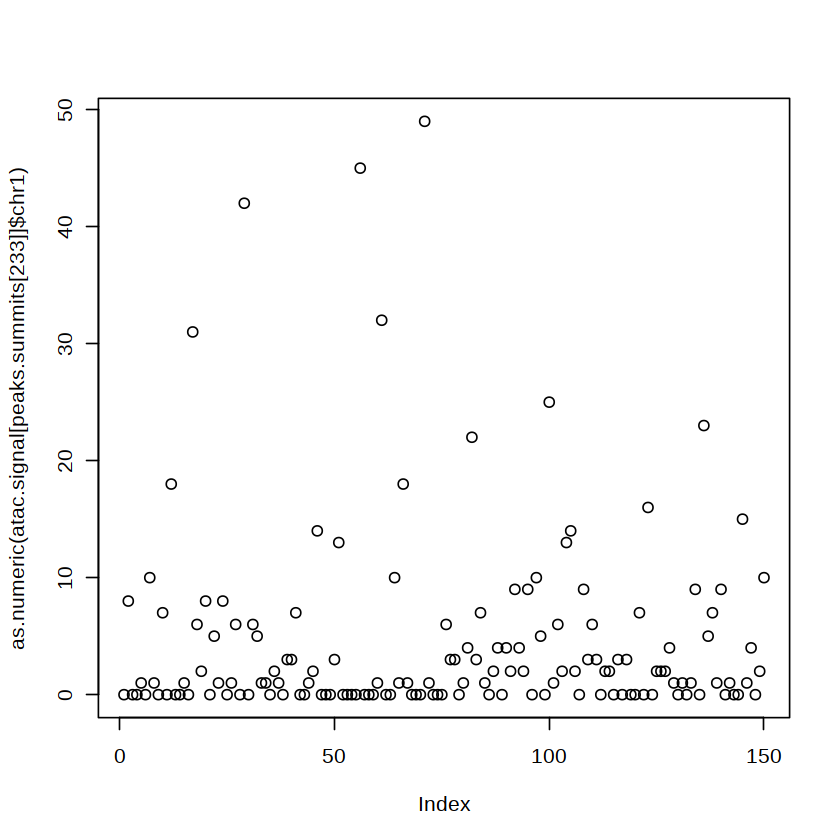

In [98]:
plot(as.numeric(atac.signal[peaks.summits[233]]$chr1))

In [91]:

export(peaks.summits, paste(motif_regression_out, "SUMMITS-all-atac-summits.bed", sep="/"))
saveRDS(peaks.summits, paste(motif_regression_out, "SUMMITS-all-atac-summits.rds", sep="/"))

In [92]:

write.table(as.data.frame(peaks.summits), paste(motif_regression_out, "SUMMITS-peak_summits.more_info.bed", sep="/"), quote= F, row.names = F, sep ="\t")